In [5]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


This time series analysis hopes to find a coorelation between accident location, type of issue, time taken to resolve issue, time of day, day of week, and month of year. This will help predict when and where an accident is likely to happen.

# Import necessary libraries

In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline


# Data Collection/Organization

In [7]:
file = 'Real-Time_Traffic_Incident_Reports.csv'


In [8]:

df = pd.read_csv(file, parse_dates=['Published Date', 'Status Date'])

df.head()
#I wanted to see what the data looked like in pandas. 


,Traffic Report ID,Published Date,Issue Reported,Location,Latitude,Longitude,Address,Status,Status Date
0,C163BCD1CF90C984E9EDA4DBA311BCA369A7D1A1_15288...,2018-06-13 06:35:59+00:00,Crash Service,"(30.283797,-97.741906)",30.283797,-97.741906,W 21ST ST & GUADALUPE ST,ARCHIVED,2018-06-13 09:00:03+00:00
1,6B20382196FB454E9FD06A33E60142902A2F0706_15288...,2018-06-13 10:15:36+00:00,Traffic Hazard,"(30.339593,-97.700963)",30.339593,-97.700963,400-717 E ANDERSON LN EB,ARCHIVED,2018-06-13 11:20:03+00:00
2,2A7A84FC69D56A2C379C274D2F0831442D3E7B8E_15871...,2020-04-17 21:25:03+00:00,Crash Urgent,"(30.329455,-97.638105)",30.329455,-97.638105,E US 290 HWY SVRD EB & EASTERN HEIGHTS BLVD,ARCHIVED,2020-04-17 21:55:03+00:00
3,89D3B75BB5932F10D25B5852A9902DA26C3DF11A_15871...,2020-04-17 21:40:52+00:00,Traffic Hazard,"(30.202806,-97.760701)",30.202806,-97.760701,5300-blk S Ih 35 Sb,ARCHIVED,2020-04-17 21:55:03+00:00
4,E7F9EFF0E81057A5C8FE41CABE4D9C6EEA82DAA0_15871...,2020-04-17 21:00:55+00:00,Crash Urgent,"(30.184265,-97.687339)",30.184265,-97.687339,4500-4720 S Us 183 Hwy Sb,ARCHIVED,2020-04-17 23:30:04+00:00


In [9]:
#df = raw_orginal.copy()


# Data Wrangling

The column names have spaces in them. This will prove to be a problem with creating visualizations later so I'm going to change the variable names for the applicable columns.

In [10]:
df=df.rename(columns = {'Published Date':'published_date'})
df=df.rename(columns = {'Status Date':'status_date'})
df=df.rename(columns = {'Issue Reported':'issue_reported'})
df=df.rename(columns = {'Traffic Report ID':'tr_ID'})
df.head()

,tr_ID,published_date,issue_reported,Location,Latitude,Longitude,Address,Status,status_date
0,C163BCD1CF90C984E9EDA4DBA311BCA369A7D1A1_15288...,2018-06-13 06:35:59+00:00,Crash Service,"(30.283797,-97.741906)",30.283797,-97.741906,W 21ST ST & GUADALUPE ST,ARCHIVED,2018-06-13 09:00:03+00:00
1,6B20382196FB454E9FD06A33E60142902A2F0706_15288...,2018-06-13 10:15:36+00:00,Traffic Hazard,"(30.339593,-97.700963)",30.339593,-97.700963,400-717 E ANDERSON LN EB,ARCHIVED,2018-06-13 11:20:03+00:00
2,2A7A84FC69D56A2C379C274D2F0831442D3E7B8E_15871...,2020-04-17 21:25:03+00:00,Crash Urgent,"(30.329455,-97.638105)",30.329455,-97.638105,E US 290 HWY SVRD EB & EASTERN HEIGHTS BLVD,ARCHIVED,2020-04-17 21:55:03+00:00
3,89D3B75BB5932F10D25B5852A9902DA26C3DF11A_15871...,2020-04-17 21:40:52+00:00,Traffic Hazard,"(30.202806,-97.760701)",30.202806,-97.760701,5300-blk S Ih 35 Sb,ARCHIVED,2020-04-17 21:55:03+00:00
4,E7F9EFF0E81057A5C8FE41CABE4D9C6EEA82DAA0_15871...,2020-04-17 21:00:55+00:00,Crash Urgent,"(30.184265,-97.687339)",30.184265,-97.687339,4500-4720 S Us 183 Hwy Sb,ARCHIVED,2020-04-17 23:30:04+00:00


Exploring the Data and Converting Datatypes

In [11]:
df.shape
#big enough

(249650, 9)

There are 249,650 rows and 9 columns

In [12]:
df.describe()
#I assume I only get one column because it's the only numerical data type(float)

,Longitude
count,249571.000000
mean,-97.551690
std,4.211096
min,-98.816154
25%,-97.776950
50%,-97.734295
75%,-97.687038
max,0.000000


# Data definition

In [13]:
df['Latitude'] = pd.to_numeric(df['Latitude'], errors = 'coerce') #Converting Latitude to numeric(float)
df.info()
#I also changed published/status date to datetime objects from string

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249650 entries, 0 to 249649
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   tr_ID           249650 non-null  object             
 1   published_date  249650 non-null  datetime64[ns, UTC]
 2   issue_reported  249650 non-null  object             
 3   Location        249107 non-null  object             
 4   Latitude        249525 non-null  float64            
 5   Longitude       249571 non-null  float64            
 6   Address         249650 non-null  object             
 7   Status          247957 non-null  object             
 8   status_date     249650 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), float64(2), object(5)
memory usage: 17.1+ MB


In [14]:
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count')


,count,%
tr_ID,0,0.000000
published_date,0,0.000000
issue_reported,0,0.000000
Address,0,0.000000
status_date,0,0.000000
Longitude,79,0.031644
Latitude,125,0.050070
Location,543,0.217505
Status,1693,0.678149


In [15]:
#The columns are missing some values are:
#Longitude - 3%
#Latitude - 5%
#Location - 21%, This will be dropped later as it is redundant and has more null values
#Status - 67%, This column will not be used for this analysis, it only inidicates whether a incident is archived or 
#not. Everything in this dataset is archived.

In [16]:
df.dropna(subset=['Latitude'],inplace=True)
df.dropna(subset=['Longitude'],inplace=True)
#Dropping null values in the above columns

### Recheck the null values

In [17]:
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count')


,count,%
tr_ID,0,0.000000
published_date,0,0.000000
issue_reported,0,0.000000
Latitude,0,0.000000
Longitude,0,0.000000
Address,0,0.000000
status_date,0,0.000000
Location,464,0.185953
Status,1691,0.677688


So I thought it may be better to create a new location variable as a float but there were far too many null values for the new split 'Location" data. Instances of null in Latitude increased by 46. I place inplace+True to solve.

Status can likely be removed entirely as it does not really serve a purpose.

I'm dropping location becasue attempts to split and convert into float datatype created too many null values to be useful. Also, I already have Lat/Lon data to use.

In [18]:
df.drop(['Location'], axis=1, inplace=True) #(use this is Location show back up)
df.drop(['Status'], axis=1, inplace=True)
df.head(3)


,tr_ID,published_date,issue_reported,Latitude,Longitude,Address,status_date
0,C163BCD1CF90C984E9EDA4DBA311BCA369A7D1A1_15288...,2018-06-13 06:35:59+00:00,Crash Service,30.283797,-97.741906,W 21ST ST & GUADALUPE ST,2018-06-13 09:00:03+00:00
1,6B20382196FB454E9FD06A33E60142902A2F0706_15288...,2018-06-13 10:15:36+00:00,Traffic Hazard,30.339593,-97.700963,400-717 E ANDERSON LN EB,2018-06-13 11:20:03+00:00
2,2A7A84FC69D56A2C379C274D2F0831442D3E7B8E_15871...,2020-04-17 21:25:03+00:00,Crash Urgent,30.329455,-97.638105,E US 290 HWY SVRD EB & EASTERN HEIGHTS BLVD,2020-04-17 21:55:03+00:00


In [19]:
issue_date = df[['issue_reported', 'published_date', 'status_date']]
issue_date.head()


,issue_reported,published_date,status_date
0,Crash Service,2018-06-13 06:35:59+00:00,2018-06-13 09:00:03+00:00
1,Traffic Hazard,2018-06-13 10:15:36+00:00,2018-06-13 11:20:03+00:00
2,Crash Urgent,2020-04-17 21:25:03+00:00,2020-04-17 21:55:03+00:00
3,Traffic Hazard,2020-04-17 21:40:52+00:00,2020-04-17 21:55:03+00:00
4,Crash Urgent,2020-04-17 21:00:55+00:00,2020-04-17 23:30:04+00:00


Subtracting the published date from the status date will help find out how long these issues take to resolve which will be useful in helping avoid parts of town. The date and time are listed together, which may come in handy when classifying the severity of issues, but the date and time values will have to be seperated when we try to decipher seasonal and time of day data. 

Changing the date columns from strings to date objects and creating a new column called issue timespan by subtracting published date from status date. There is a breakdown of different time measures for this columns in different columns.

In [20]:
issue_time = df['status_date'] - df['published_date']
issue_time.abs()
df['issue_timespan'] = issue_time
df.head()

,tr_ID,published_date,issue_reported,Latitude,Longitude,Address,status_date,issue_timespan
0,C163BCD1CF90C984E9EDA4DBA311BCA369A7D1A1_15288...,2018-06-13 06:35:59+00:00,Crash Service,30.283797,-97.741906,W 21ST ST & GUADALUPE ST,2018-06-13 09:00:03+00:00,0 days 02:24:04
1,6B20382196FB454E9FD06A33E60142902A2F0706_15288...,2018-06-13 10:15:36+00:00,Traffic Hazard,30.339593,-97.700963,400-717 E ANDERSON LN EB,2018-06-13 11:20:03+00:00,0 days 01:04:27
2,2A7A84FC69D56A2C379C274D2F0831442D3E7B8E_15871...,2020-04-17 21:25:03+00:00,Crash Urgent,30.329455,-97.638105,E US 290 HWY SVRD EB & EASTERN HEIGHTS BLVD,2020-04-17 21:55:03+00:00,0 days 00:30:00
3,89D3B75BB5932F10D25B5852A9902DA26C3DF11A_15871...,2020-04-17 21:40:52+00:00,Traffic Hazard,30.202806,-97.760701,5300-blk S Ih 35 Sb,2020-04-17 21:55:03+00:00,0 days 00:14:11
4,E7F9EFF0E81057A5C8FE41CABE4D9C6EEA82DAA0_15871...,2020-04-17 21:00:55+00:00,Crash Urgent,30.184265,-97.687339,4500-4720 S Us 183 Hwy Sb,2020-04-17 23:30:04+00:00,0 days 02:29:09


In [21]:
address_date = df[['Address', 'published_date', 'status_date']]
issue_date.head()

,issue_reported,published_date,status_date
0,Crash Service,2018-06-13 06:35:59+00:00,2018-06-13 09:00:03+00:00
1,Traffic Hazard,2018-06-13 10:15:36+00:00,2018-06-13 11:20:03+00:00
2,Crash Urgent,2020-04-17 21:25:03+00:00,2020-04-17 21:55:03+00:00
3,Traffic Hazard,2020-04-17 21:40:52+00:00,2020-04-17 21:55:03+00:00
4,Crash Urgent,2020-04-17 21:00:55+00:00,2020-04-17 23:30:04+00:00


In [22]:
df['issue_reported'].unique()

array(['Crash Service', 'Traffic Hazard', 'Crash Urgent', 'VEHICLE FIRE',
       'TRFC HAZD/ DEBRIS', 'COLLISION WITH INJURY', 'zSTALLED VEHICLE',
       'COLLISION', 'COLLISN/ LVNG SCN', 'LOOSE LIVESTOCK',
       'Stalled Vehicle', 'BLOCKED DRIV/ HWY',
       'COLLISION/PRIVATE PROPERTY', 'BOAT ACCIDENT', 'FLEET ACC/ INJURY',
       'Traffic Impediment', 'AUTO/ PED', 'TRAFFIC FATALITY',
       'OBSTRUCT HWY', 'ICY ROADWAY', 'COLLISN / FTSRA',
       'N / HZRD TRFC VIOL', 'HIGH WATER', 'FLEET ACC/ FATAL'],
      dtype=object)

In [23]:
df['Address'].value_counts()

E Parmer Ln & Dessau Rd                  177
9300 S Ih 35 Svrd Sb                     164
E Riverside Dr & S Pleasant Valley Rd    156
Fm 969 Rd & N Fm 973 Rd                  154
Dessau Rd & E Parmer Ln                  150
                                        ... 
11000 S Sh 130 Svrd Nb                     1
9912 Giles Ln                              1
3300-3800 S LAMAR BLVD                     1
S 4th St & W Oltorf St                     1
1000-1004 W HOWARD LN                      1
Name: Address, Length: 82604, dtype: int64

Clearly some Adresses are more prone to accidents. These appear to be a series of intersections that can also be
identified through location data. Example: E Parmer Ln & Dessau Rd (177 issues reported) is location
30.387004,-97.648592 (381 issues reported). This suggests that perhaps the location indicator may be more accurate
even though addresses are easier to communicate.

#### I wanted to know what day of the week certain issues happened along with the volume of issue per day.
##### Hense, these datetime objects are converted into the days of the week 
##### 0 = Monday, 6 = Sunday and can be found on the published_day/status_day columns

In [24]:
pub_day = df['published_date'].dt.dayofweek
df['published_day'] = pub_day
pub_day = df['status_date'].dt.dayofweek
df['status_day'] = pub_day

df.head()

,tr_ID,published_date,issue_reported,Latitude,Longitude,Address,status_date,issue_timespan,published_day,status_day
0,C163BCD1CF90C984E9EDA4DBA311BCA369A7D1A1_15288...,2018-06-13 06:35:59+00:00,Crash Service,30.283797,-97.741906,W 21ST ST & GUADALUPE ST,2018-06-13 09:00:03+00:00,0 days 02:24:04,2,2
1,6B20382196FB454E9FD06A33E60142902A2F0706_15288...,2018-06-13 10:15:36+00:00,Traffic Hazard,30.339593,-97.700963,400-717 E ANDERSON LN EB,2018-06-13 11:20:03+00:00,0 days 01:04:27,2,2
2,2A7A84FC69D56A2C379C274D2F0831442D3E7B8E_15871...,2020-04-17 21:25:03+00:00,Crash Urgent,30.329455,-97.638105,E US 290 HWY SVRD EB & EASTERN HEIGHTS BLVD,2020-04-17 21:55:03+00:00,0 days 00:30:00,4,4
3,89D3B75BB5932F10D25B5852A9902DA26C3DF11A_15871...,2020-04-17 21:40:52+00:00,Traffic Hazard,30.202806,-97.760701,5300-blk S Ih 35 Sb,2020-04-17 21:55:03+00:00,0 days 00:14:11,4,4
4,E7F9EFF0E81057A5C8FE41CABE4D9C6EEA82DAA0_15871...,2020-04-17 21:00:55+00:00,Crash Urgent,30.184265,-97.687339,4500-4720 S Us 183 Hwy Sb,2020-04-17 23:30:04+00:00,0 days 02:29:09,4,4


#### Converting issue_timespan column into seconds

In [25]:
issue_timespan_sec = df['issue_timespan'].value_counts()
df['issue_reported_value'] = issue_timespan_sec
df.head()

,tr_ID,published_date,issue_reported,Latitude,Longitude,Address,status_date,issue_timespan,published_day,status_day,issue_reported_value
0,C163BCD1CF90C984E9EDA4DBA311BCA369A7D1A1_15288...,2018-06-13 06:35:59+00:00,Crash Service,30.283797,-97.741906,W 21ST ST & GUADALUPE ST,2018-06-13 09:00:03+00:00,0 days 02:24:04,2,2,NaN
1,6B20382196FB454E9FD06A33E60142902A2F0706_15288...,2018-06-13 10:15:36+00:00,Traffic Hazard,30.339593,-97.700963,400-717 E ANDERSON LN EB,2018-06-13 11:20:03+00:00,0 days 01:04:27,2,2,NaN
2,2A7A84FC69D56A2C379C274D2F0831442D3E7B8E_15871...,2020-04-17 21:25:03+00:00,Crash Urgent,30.329455,-97.638105,E US 290 HWY SVRD EB & EASTERN HEIGHTS BLVD,2020-04-17 21:55:03+00:00,0 days 00:30:00,4,4,NaN
3,89D3B75BB5932F10D25B5852A9902DA26C3DF11A_15871...,2020-04-17 21:40:52+00:00,Traffic Hazard,30.202806,-97.760701,5300-blk S Ih 35 Sb,2020-04-17 21:55:03+00:00,0 days 00:14:11,4,4,NaN
4,E7F9EFF0E81057A5C8FE41CABE4D9C6EEA82DAA0_15871...,2020-04-17 21:00:55+00:00,Crash Urgent,30.184265,-97.687339,4500-4720 S Us 183 Hwy Sb,2020-04-17 23:30:04+00:00,0 days 02:29:09,4,4,NaN


#### I will also convert the timespan from seconds to minutes and hours.

In [26]:
df['timespan_sec'] = df.issue_timespan.apply(lambda x: x.total_seconds())
df['timespan_min'] = df['timespan_sec']/60
df['timespan_hrs'] = df['timespan_min']/60
df.head()

,tr_ID,published_date,issue_reported,Latitude,Longitude,Address,status_date,issue_timespan,published_day,status_day,issue_reported_value,timespan_sec,timespan_min,timespan_hrs
0,C163BCD1CF90C984E9EDA4DBA311BCA369A7D1A1_15288...,2018-06-13 06:35:59+00:00,Crash Service,30.283797,-97.741906,W 21ST ST & GUADALUPE ST,2018-06-13 09:00:03+00:00,0 days 02:24:04,2,2,NaN,8644.0,144.066667,2.401111
1,6B20382196FB454E9FD06A33E60142902A2F0706_15288...,2018-06-13 10:15:36+00:00,Traffic Hazard,30.339593,-97.700963,400-717 E ANDERSON LN EB,2018-06-13 11:20:03+00:00,0 days 01:04:27,2,2,NaN,3867.0,64.450000,1.074167
2,2A7A84FC69D56A2C379C274D2F0831442D3E7B8E_15871...,2020-04-17 21:25:03+00:00,Crash Urgent,30.329455,-97.638105,E US 290 HWY SVRD EB & EASTERN HEIGHTS BLVD,2020-04-17 21:55:03+00:00,0 days 00:30:00,4,4,NaN,1800.0,30.000000,0.500000
3,89D3B75BB5932F10D25B5852A9902DA26C3DF11A_15871...,2020-04-17 21:40:52+00:00,Traffic Hazard,30.202806,-97.760701,5300-blk S Ih 35 Sb,2020-04-17 21:55:03+00:00,0 days 00:14:11,4,4,NaN,851.0,14.183333,0.236389
4,E7F9EFF0E81057A5C8FE41CABE4D9C6EEA82DAA0_15871...,2020-04-17 21:00:55+00:00,Crash Urgent,30.184265,-97.687339,4500-4720 S Us 183 Hwy Sb,2020-04-17 23:30:04+00:00,0 days 02:29:09,4,4,NaN,8949.0,149.150000,2.485833


#### THe tr_id is too long and make the head hard to read. I decided to shorten it as well as making it the new index.

df['short_ID'] = df['tr_ID'].str.slice(0,3)
df = df.drop('tr_ID', 1)
df = df.drop('Status', 1)
df = df.drop('issue_reported_value', 1)
df.head()

df.set_index('short_ID', inplace = True)
df.head()

#### I'm looking to see if there is much difference between plublished_day and status day.
##### I was considering dropping some rows if the number was insignificant. 

In [27]:
df.loc[~(df['published_day'] == df['status_day'])]

,tr_ID,published_date,issue_reported,Latitude,Longitude,Address,status_date,issue_timespan,published_day,status_day,issue_reported_value,timespan_sec,timespan_min,timespan_hrs
5,5E777B99E8FD7269347B6E0FC10C15797B83CF22_15871...,2020-04-17 21:44:39+00:00,Crash Urgent,30.353742,-97.690482,9001 N Ih 35 Svrd Nb,2020-04-18 00:05:28+00:00,0 days 02:20:49,4,5,NaN,8449.0,140.816667,2.346944
19,456ECC26A705746349AAEE35B187F91A3FA088FC_15874...,2020-04-21 10:45:58+00:00,VEHICLE FIRE,30.431001,-97.940508,5973 Hi Line Rd,2020-04-22 03:20:04+00:00,0 days 16:34:06,1,2,NaN,59646.0,994.100000,16.568333
39,FF33A8F10515011CBA0D191AE58F7F9A4DD7A3E1_15871...,2020-04-17 23:29:26+00:00,Crash Service,30.205068,-97.775196,107 W STASSNEY LN,2020-04-18 00:00:05+00:00,0 days 00:30:39,4,5,NaN,1839.0,30.650000,0.510833
40,2B669C9296380E84B1308058C9C5E6917A9510E9_15871...,2020-04-17 22:53:45+00:00,Crash Urgent,30.229962,-97.864551,W William Cannon Dr & Escarpment Blvd,2020-04-18 00:40:04+00:00,0 days 01:46:19,4,5,NaN,6379.0,106.316667,1.771944
63,23C48E1AA4867FD335AC3497FA1061DE28CC7819_16039...,2020-10-28 23:47:11+00:00,COLLISN/ LVNG SCN,30.438657,-97.671975,14600 Owen Tech Blvd,2020-10-29 00:05:03+00:00,0 days 00:17:52,2,3,NaN,1072.0,17.866667,0.297778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249550,B33901810898401751A5BAFB281025DC4CEEB37B_16393...,2021-12-12 22:05:40+00:00,Crash Service,30.366005,-97.683512,10100 N Ih 35 Svrd Sb,2021-12-13 00:35:03+00:00,0 days 02:29:23,6,0,NaN,8963.0,149.383333,2.489722
249552,2B348A807FBA80C79943FFD86758097907A6AF79_16393...,2021-12-12 23:56:32+00:00,Crash Service,30.162182,-97.789085,9500 S Ih 35 Svrd Sb,2021-12-13 00:50:04+00:00,0 days 00:53:32,6,0,NaN,3212.0,53.533333,0.892222
249553,FF1EB8BD6CB17940AB78C0EEECF66268772F2061_16393...,2021-12-12 22:58:12+00:00,Crash Urgent,30.448448,-97.791588,9600-9617 Anderson Mill Rd,2021-12-13 01:05:04+00:00,0 days 02:06:52,6,0,NaN,7612.0,126.866667,2.114444
249555,138825ED8F4199D67F9CA400B795B65FEC1158AC_16393...,2021-12-12 23:07:15+00:00,Crash Urgent,30.169280,-97.795827,W Slaughter Ln & Francia Trl,2021-12-13 01:15:03+00:00,0 days 02:07:48,6,0,NaN,7668.0,127.800000,2.130000


#### The number was not insignificant.

df.drop('issue_reported_value', axis=1, inplace=True)
#I'm dropping this column as it has no values.
df.head(2)

# Exploratory Data Analysis

#### We can deduce that it is impossible to have a negative timespan when it come to traffic issues being resolved.
##### We can call the .abs() function to solve this issue.

In [28]:
df.timespan_hrs = df['timespan_hrs'].abs()

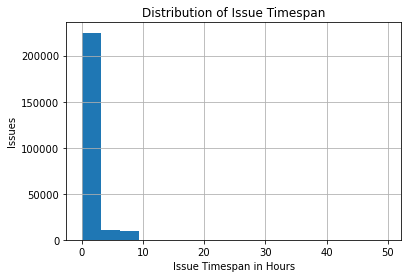

In [29]:
df.timespan_hrs[df.timespan_hrs < 64].hist(bins=16)
plt.xlabel('Issue Timespan in Hours')
plt.ylabel('Issues')
plt.title('Distribution of Issue Timespan');

Most of the data points lie within 10 hours, and even that may be too generous based on the graph above.

In [30]:
#### This is a very high average, something is not right.

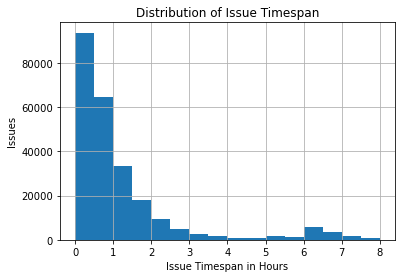

In [31]:
df.timespan_hrs[df.timespan_hrs < 8].hist(bins=16)
plt.xlabel('Issue Timespan in Hours')
plt.ylabel('Issues')
plt.title('Distribution of Issue Timespan');

The timespan data paints a better picture within an 8 hour timeframe. Hense, I will focus on the first eight hours.

In [32]:
df = df[df.timespan_hrs < 8.0]
df.shape

(244652, 14)

In [33]:
avg_mean = df['issue_timespan'].mean()
print(avg_mean)
avg_mean.total_seconds()

0 days 01:12:36.557469385


4356.557469

The average issue timespan is a little over 1 hour. 

In [34]:
min_span = df['issue_timespan'].min()
print(min_span)
min_span.total_seconds()

0 days 00:00:20


20.0

The minimum amount of time to resolve a traffic issue was 20 seconds

In [35]:
max_span = df['issue_timespan'].max()
print(max_span)
max_span.total_seconds()

0 days 07:59:44


28784.0

The maximum time spent resolving a traffic issue is 7:59:44

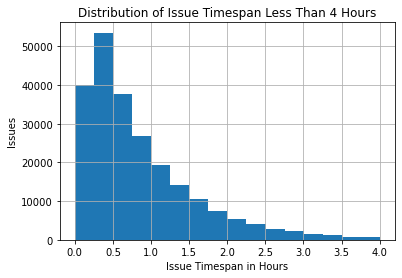

In [36]:
df.timespan_hrs[df.timespan_hrs < 4].hist(bins=16)
plt.xlabel('Issue Timespan in Hours')
plt.ylabel('Issues')
plt.title('Distribution of Issue Timespan Less Than 4 Hours');


This plot shows the average timespan of a given issue in hours. As you can see most issues are resolved in less than
half an hour (0.5 hours). Issues that take over 1 1/2 hours are relatively small in number compared to those that take less than that amount of time.

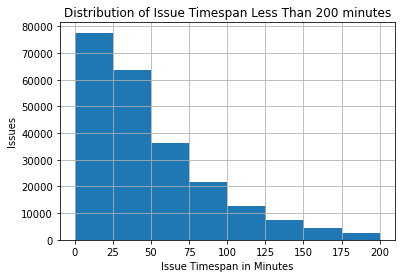

In [37]:
df.timespan_min[df.timespan_min < 200].hist(bins=8)
plt.xlabel('Issue Timespan in Minutes')
plt.ylabel('Issues')
plt.title('Distribution of Issue Timespan Less Than 200 minutes');

I double checked using time in minutes to make sure that the pattern stayed the same, and it did. 

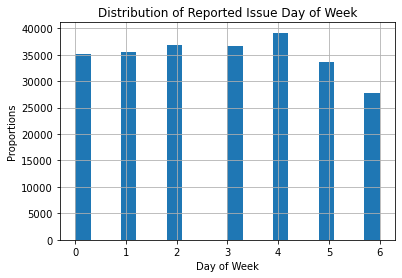

In [38]:
df.published_day.hist(bins=20)
plt.xlabel('Day of Week')
plt.ylabel('Proportions')
plt.title('Distribution of Reported Issue Day of Week');

##Plot Key 
- 0 = Monday  
- 1 = Tuesday
- 2 = Wednesday
- 3 = Thursday
- 4 = Friday
- 5 = Saturday
- 6 = Sunday


We can see that the highest instances of traffic incidents happen of Friday, which is to be expected due to a lively nightlife. Conversely, Sunday has the least amount of incidents as most people are resting and preparing for the work week.

Monday and Tuesday hold steady at around 35,0000
Wednesday and Thursday there is a slight increase to around 37,000
Saturday has less instances than weekdays at about 33,000

# Volume of Unique Issues Reported Over 100

In [39]:
df = df.groupby('issue_reported').filter(lambda x : len(x)>100)
df.shape

(244340, 14)

In [40]:
df['issue_reported'].value_counts()


Traffic Hazard                75853
Crash Urgent                  57455
Crash Service                 36396
COLLISION                     21571
TRFC HAZD/ DEBRIS             17332
zSTALLED VEHICLE               8759
LOOSE LIVESTOCK                5923
Traffic Impediment             5879
COLLISION WITH INJURY          5861
COLLISN/ LVNG SCN              4214
Stalled Vehicle                2842
COLLISION/PRIVATE PROPERTY      955
VEHICLE FIRE                    800
BLOCKED DRIV/ HWY               500
Name: issue_reported, dtype: int64

Unsure about the meaning of some of these headings mean but it may be worth looking at the average timespan of each unique issue. This list shows issues that ocurred at least 500 times.

## Visualizing the Volume of Issues Reported

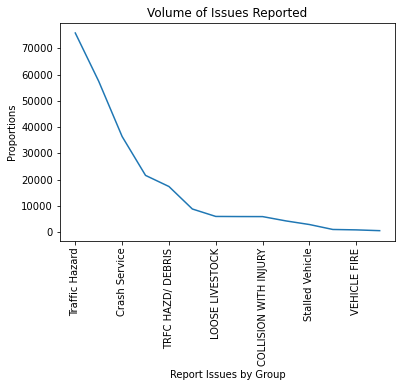

In [41]:
issue_counts = df['issue_reported'].value_counts()
issue_counts.plot( rot=90)
plt.xlabel("Report Issues by Group")
plt.ylabel("Proportions")
plt.title('Volume of Issues Reported')
plt.show()

This is a visual representation of incident volume. Traffic Hazard happen by far the most, while highway obstruction ocurrs the least.

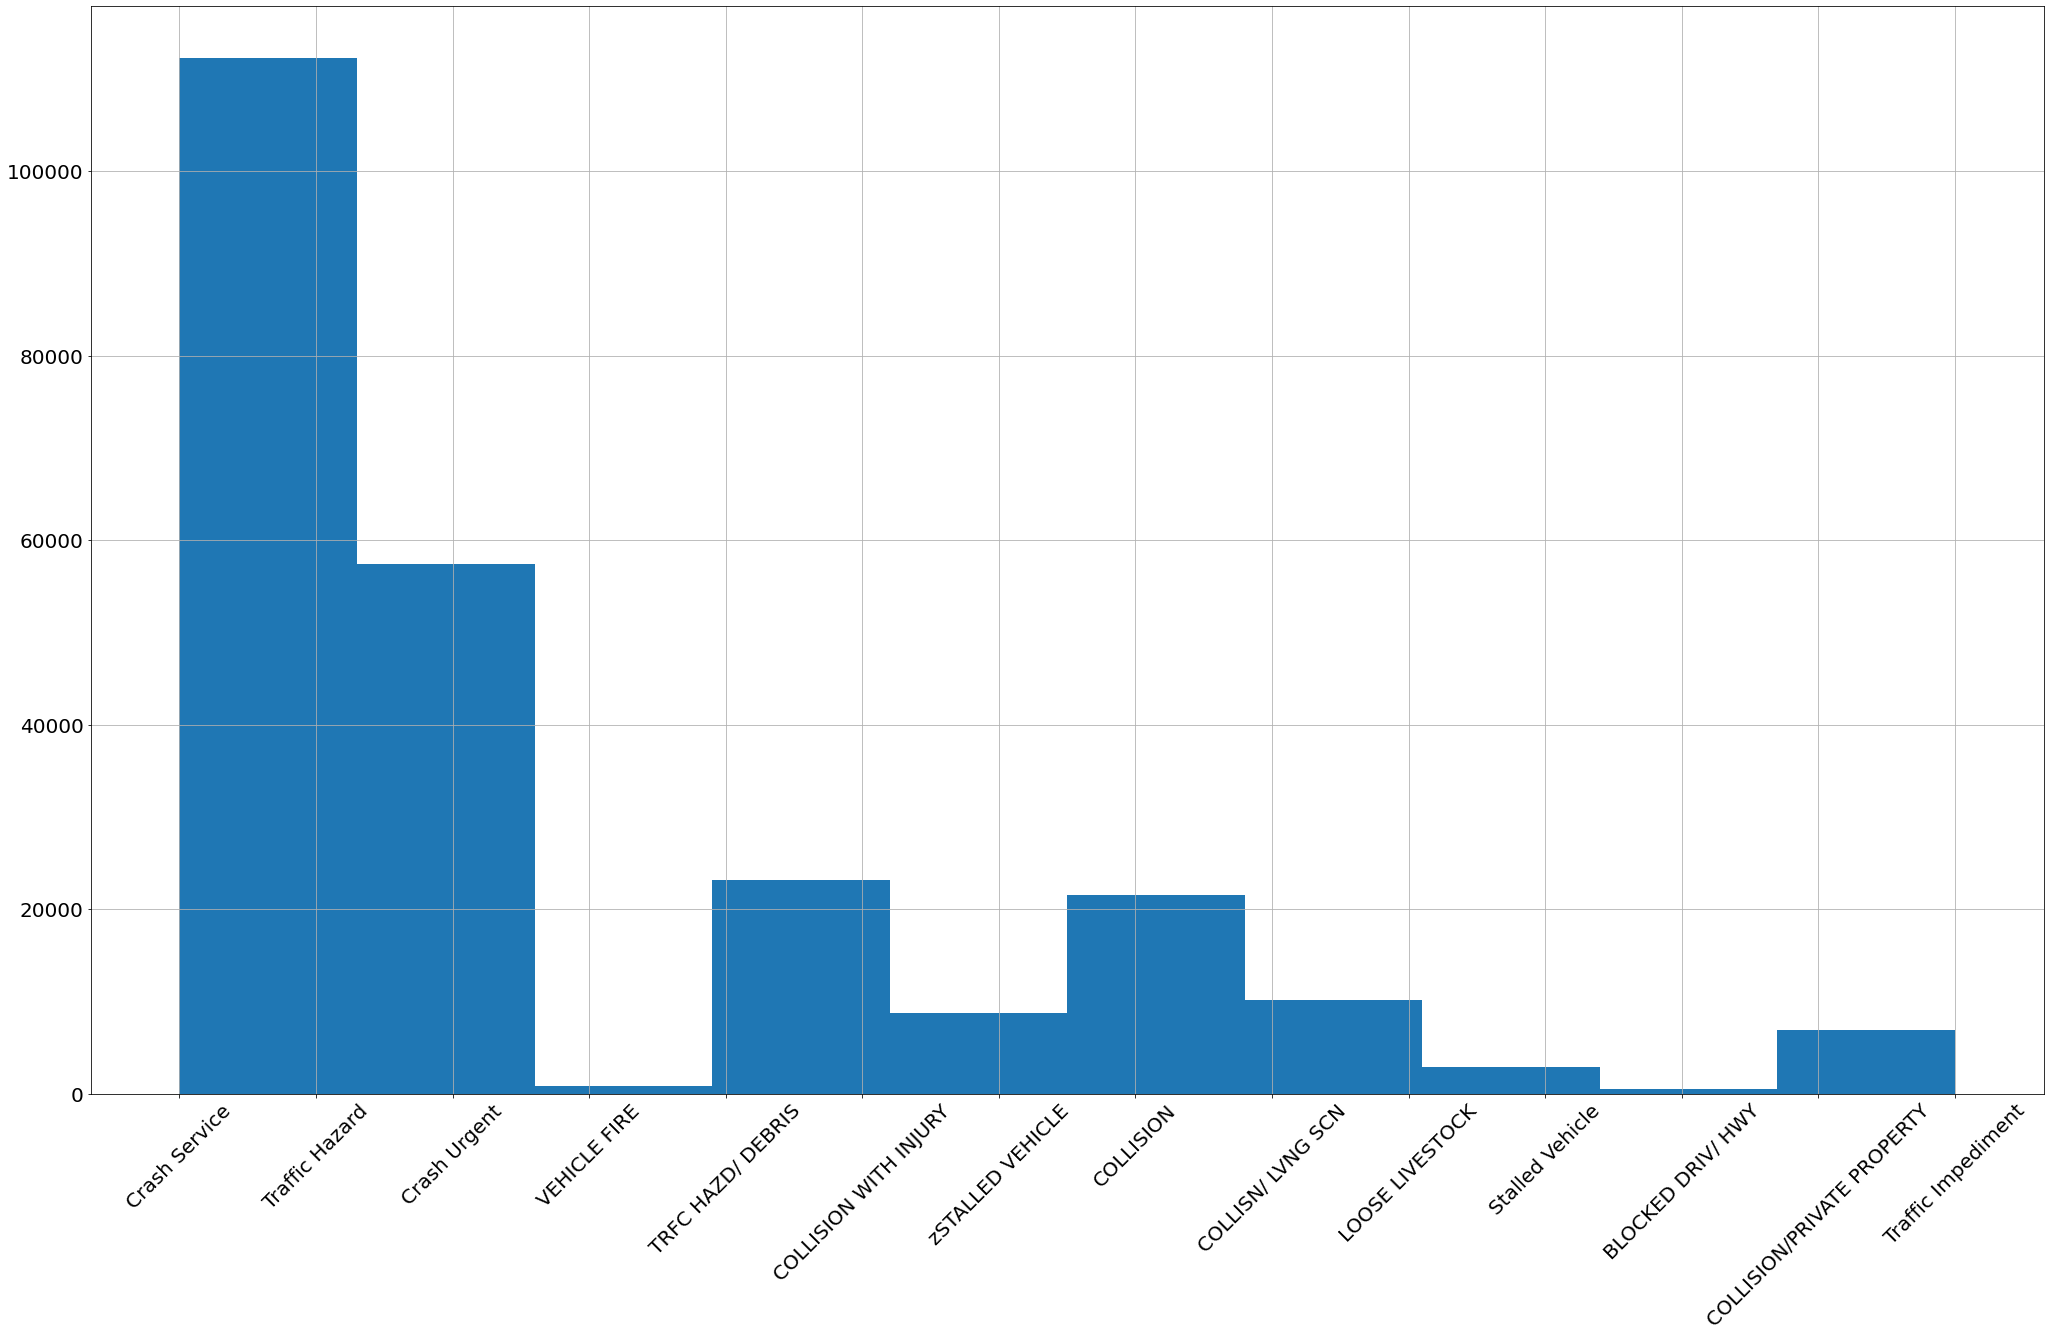

In [43]:
df.issue_reported.hist(figsize=(35,20))
plt.xticks(fontsize = 20, rotation=45)
plt.yticks(fontsize = 20)
plt.show()


#The histograph above includes issues that we too sparse to be part of the initial line plot. As one can see, traffic #impediment barely happens and we know 



In [45]:
#df.plot.line(x='timespan_min', y='issue_reported')
#Why doesn't this work?

I wanted to see how many rows had different published/status days. I was considering dropping the rows if the 
instances were low. They were not. I will essentially just be using the published day for most of the anaysis.

The next thing I need to do is take latitude and logitude and put them in a scatter plot over a map.

In [49]:
crs = {'init': 'epsg:4326'}

In [50]:
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
geometry[:3]

In [51]:
geo_df = gdp.GeoDataFrame(df,
                         crs = crs,
                         geometry = geometry)
geo_df.head()

NameError: name 'gdp' is not defined

NameError: name 'street_map' is not defined

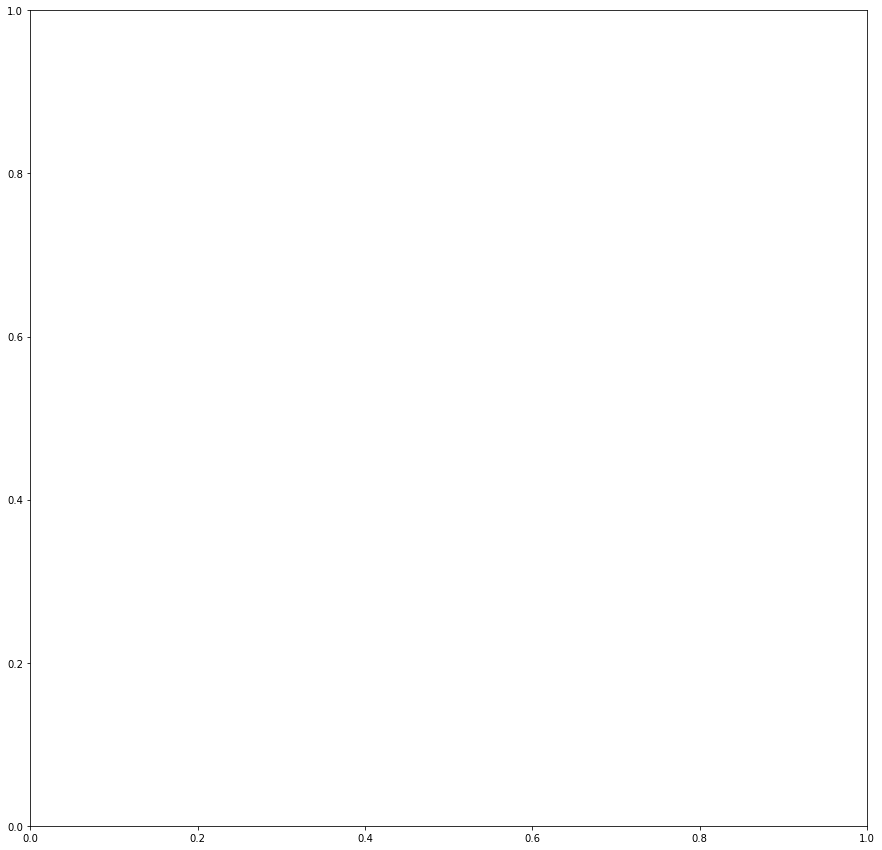

In [52]:
fig,ax =plt.subplots(figsize=(15,15))
street_map.plot(ax = ax, alpha = 0.4, color='grey')
geo_df[geo_df['WnvPresent'] ==0].plot(ax = ax, markersize = 20, color = 'blue',marker = '=o', label = 'Neg')
geo_df[geo_df['WnvPresent'] ==1].plot(ax = ax, markersize = 20, color = 'red',marker = '^', label = 'Pos')
plt.legend(prop={'size': 15})

There are many 'Latitude' and some 'Logitude' null values so I tried splitting the 'Location' column into two different strings and converting them to numbers. This resulted in even more null values so I scrapped the idea.